In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

class model(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,stride=1,padding=2, padding_mode='zeros')
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=2)
        self.fc = nn.Linear(in_features=4232, out_features=n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=1)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=3,stride=1)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=3,stride=1)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.avg_pool2d(x,kernel_size=3,stride=1)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x


def train(model, train_loader,valid_loader, optimizer, criterion, device,epochs = 10):

    history = {'train':{'loss':[],'accuracy':[]}, 'valid':{'loss':[],'accuracy':[]}}
    n = len(train_loader)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        Loss_epoch = 0
        correct = 0
        total = 0
        evaluation_train = {'accuracy':0, 'loss':0}
        for idx, data in enumerate(tqdm(train_loader)):
            input, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()


            Loss_epoch += loss.item()*len(labels)
            correct += accuracy(output, labels)*len(labels)
            total += len(labels)
        # Loss_history.append(Loss_epoch/n)
        evaluation_train['accuracy'] = correct/total
        evaluation_train['loss'] =  Loss_epoch/total
        # evaluation_train = evaluate(model, train_loader,criterion, device)
        evaluation_valid,_ = evaluate(model, valid_loader,criterion, device)
        print(f'train: {evaluation_train}, valid: {evaluation_valid}')
        history['train']['accuracy'].append(evaluation_train['accuracy'])
        history['train']['loss'].append(evaluation_train['loss'])



        history['valid']['loss'].append(evaluation_valid['loss'])
        history['valid']['accuracy'].append(evaluation_valid['accuracy'])
    return history


def accuracy(output, labels):
    _, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)).item()

def evaluate(model,data_loader, criterion, device,return_preds = False):
    model.eval()
    Accuracy_history = []
    Loss_history = []
    PREDS = []
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input, target = data[0].to(device), data[1].to(device)
            output = model(input)
            loss = criterion(output, target)
            Accuracy_history.append(accuracy(output, target))
            Loss_history.append(loss.item())
            if return_preds:
                PREDS.extend(torch.max(output, dim=1)[1].tolist())
    return {'accuracy': torch.mean(torch.Tensor(Accuracy_history)).item(), 'loss': torch.mean(torch.Tensor(Loss_history)).item()}, PREDS



In [29]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.PILToTensor(),
     transforms.ConvertImageDtype(torch.float),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

batch_size = 16

dataset = ImageFolder(root='./data', transform=transform)

val_size = 50
train_size = len(dataset) - val_size

trainset, testset = random_split(dataset, [train_size, val_size])
len(trainset), len(testset)



trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = dataset.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


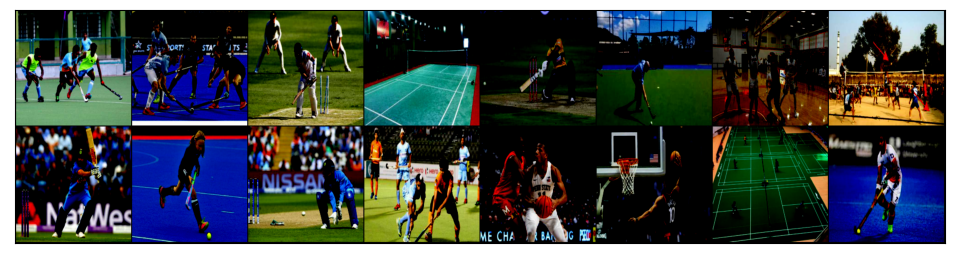

In [109]:
from torchvision.utils import make_grid

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
show_batch(trainloader)

In [116]:
epochs = 10
n_classes = len(classes)
model_train = model(n_classes)
history = train(model_train, trainloader, testloader, optim.Adam(model_train.parameters(), lr=0.001), nn.CrossEntropyLoss(), 'cuda', epochs=epochs)

  0%|          | 0/38 [00:00<?, ?it/s]

100%|██████████| 38/38 [00:05<00:00,  7.13it/s]


train: {'accuracy': 0.2348993288590604, 'loss': 1.579155283486283}, valid: {'accuracy': 0.03125, 'loss': 1.6785776615142822}


100%|██████████| 38/38 [00:05<00:00,  7.04it/s]


train: {'accuracy': 0.35570469798657717, 'loss': 1.4983567535477196}, valid: {'accuracy': 0.265625, 'loss': 1.5534412860870361}


100%|██████████| 38/38 [00:05<00:00,  6.98it/s]


train: {'accuracy': 0.5318791946308725, 'loss': 1.3682968352465021}, valid: {'accuracy': 0.484375, 'loss': 1.3539531230926514}


100%|██████████| 38/38 [00:05<00:00,  7.21it/s]


train: {'accuracy': 0.610738255033557, 'loss': 1.2864921701034444}, valid: {'accuracy': 0.578125, 'loss': 1.253868818283081}


100%|██████████| 38/38 [00:05<00:00,  7.12it/s]


train: {'accuracy': 0.6493288590604027, 'loss': 1.2593503550395069}, valid: {'accuracy': 0.6875, 'loss': 1.2313859462738037}


100%|██████████| 38/38 [00:05<00:00,  7.28it/s]


train: {'accuracy': 0.6543624161073825, 'loss': 1.245147735080463}, valid: {'accuracy': 0.765625, 'loss': 1.1951916217803955}


100%|██████████| 38/38 [00:05<00:00,  7.25it/s]


train: {'accuracy': 0.7130872483221476, 'loss': 1.1885522667993635}, valid: {'accuracy': 0.734375, 'loss': 1.1569974422454834}


100%|██████████| 38/38 [00:05<00:00,  7.27it/s]


train: {'accuracy': 0.7030201342281879, 'loss': 1.1930012262907603}, valid: {'accuracy': 0.71875, 'loss': 1.184380054473877}


100%|██████████| 38/38 [00:05<00:00,  7.25it/s]


train: {'accuracy': 0.7466442953020134, 'loss': 1.161027917125881}, valid: {'accuracy': 0.75, 'loss': 1.1335060596466064}


100%|██████████| 38/38 [00:05<00:00,  6.99it/s]


train: {'accuracy': 0.6963087248322147, 'loss': 1.2075723773681077}, valid: {'accuracy': 0.78125, 'loss': 1.1241587400436401}


In [141]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

model = model_train
target_layers = [model.conv4]
input_tensor,target_label = next(iter(testloader))

cam = GradCAM(model=model, target_layers=target_layers)

grayscale_cam = cam(input_tensor=input_tensor, targets=None, eigen_smooth=True,aug_smooth=True)
model_outputs = cam.outputs


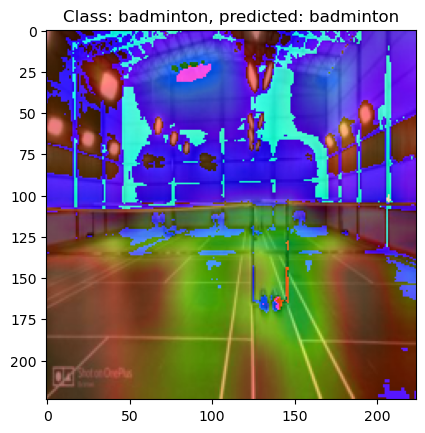

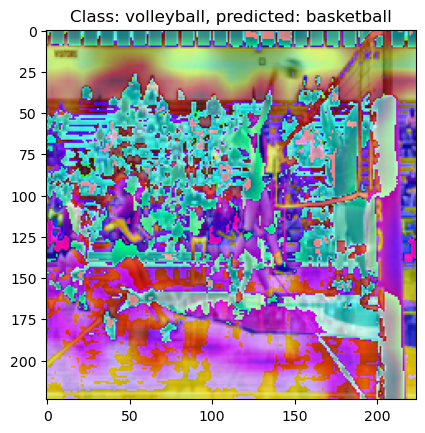

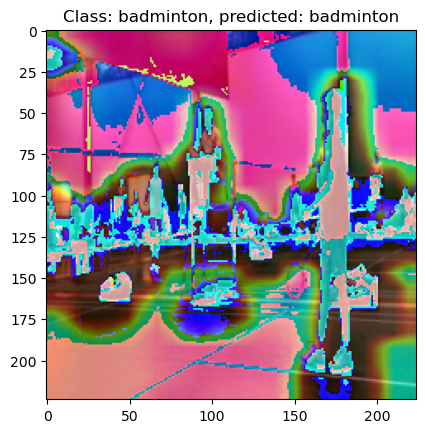

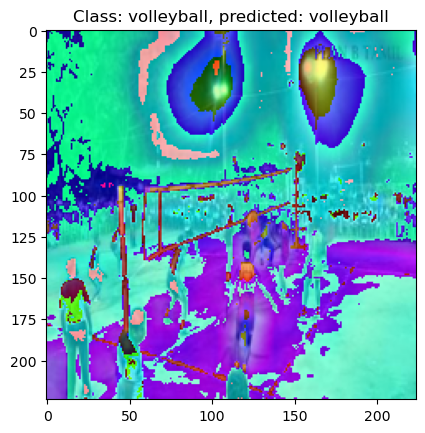

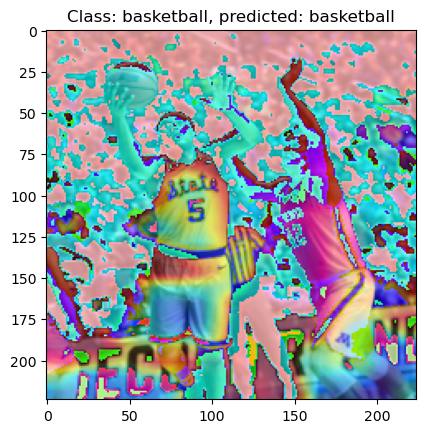

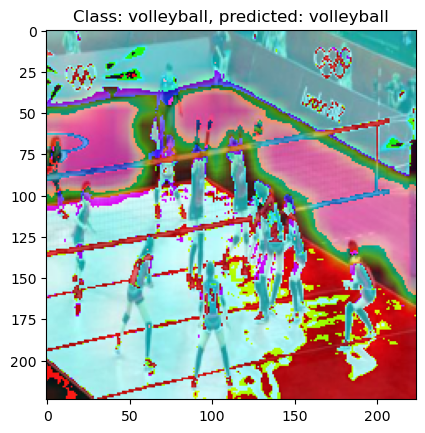

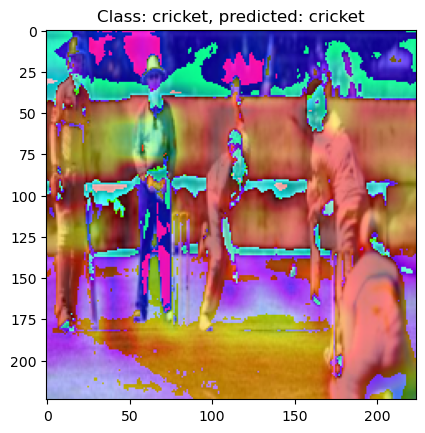

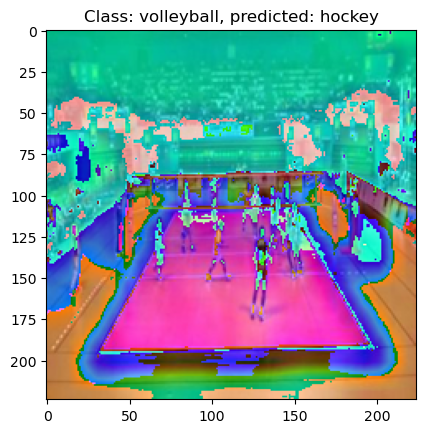

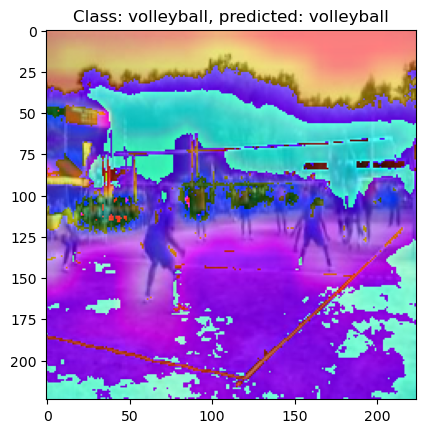

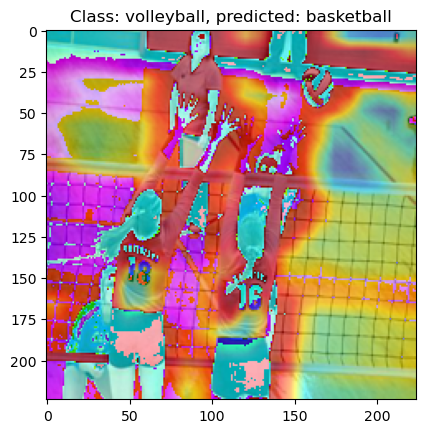

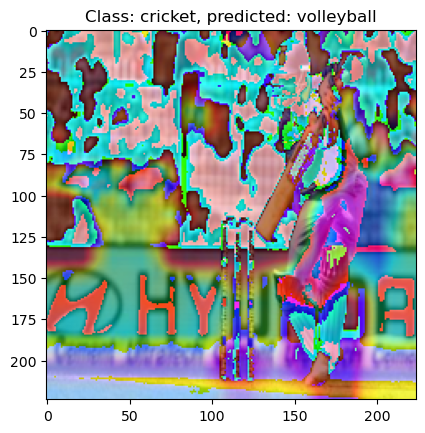

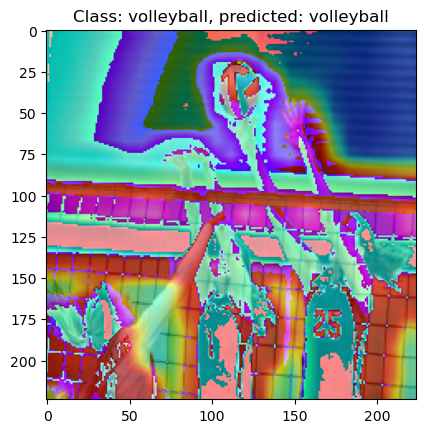

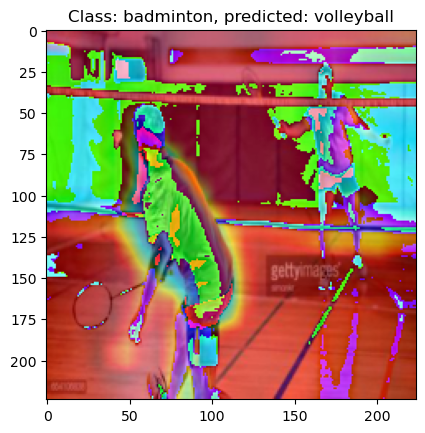

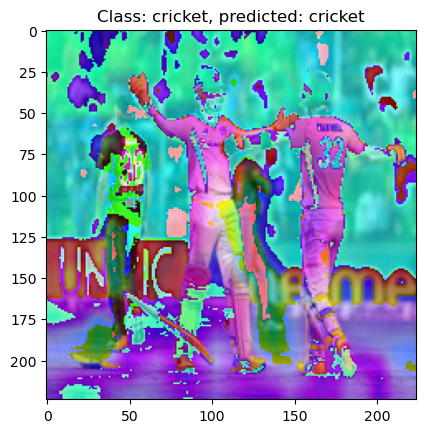

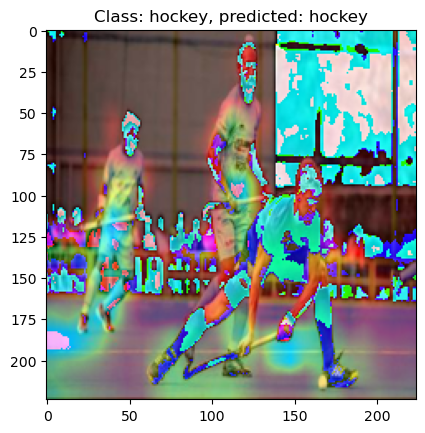

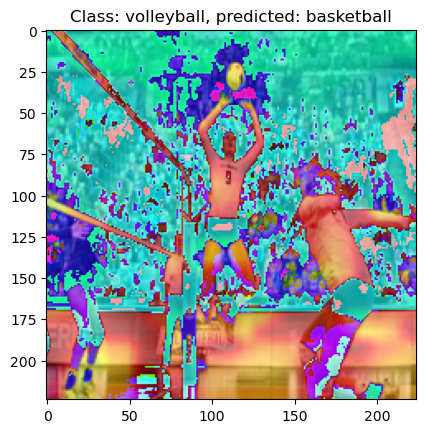

In [142]:

for i in range(grayscale_cam.shape[0]):
    grayscale_cam_image = grayscale_cam[i]
    img = input_tensor[i]
    visualization = show_cam_on_image(img.permute(1,2,0).numpy(), grayscale_cam_image, use_rgb=False)
    plt.imshow(visualization)
    plt.title(f'Class: {classes[target_label[i]]}, predicted: {classes[torch.argmax(model_outputs[i])]}')
    plt.show()

